In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import wind_force, vector_to_xy_components, get_mass_matrix
import pandas as pd

In [ ]:
current_velocity = IntegratedWhiteNoise(0, 0.514, 0.1, 0.001)
current_direction = IntegratedWhiteNoise(0, 360, 100, 1)
wind_velocity = IntegratedWhiteNoise(0, 7.716, 2, 2)
wind_direction = IntegratedWhiteNoise(0, 360, 200, 7)

wind = np.zeros((5, 100))
for i in range(100):
    wind[0, i] = wind_velocity.get_value()
    wind[1, i] = wind_direction.get_value()
    vec = vector_to_xy_components(wind[0, i], wind[1, i])
    wind[2:, i] = wind_force(vec, wind[1, i], np.array([0, 0, 0]))

pd.DataFrame(wind)

In [ ]:
mass_inv = np.linalg.inv(get_mass_matrix())
mass_inv

In [20]:
h = 0.01
it = 10000

vel = np.zeros((3, it))
for i in range(it-1):
    v = wind_velocity.get_value()
    d = wind_direction.get_value()
    vec = vector_to_xy_components(v, d)
    # f = wind_force(vec, d, vel[:, i])
    f = np.array([10, 0, 0])

    vel[:, i+1] = vel[:, i] + h * mass_inv.dot(np.array([10*np.log((i)+1), 0, 0]) + f)

print(vel.shape)
vel[:, :1000]

(3, 10000)


array([[0.00000000e+00, 1.95837891e-04, 5.27420264e-04, ...,
        1.34901128e+00, 1.35055953e+00, 1.35210797e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

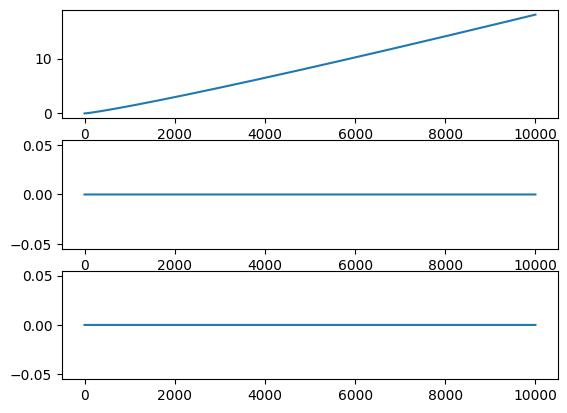

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(range(it), vel[0, :])
ax2.plot(range(it), vel[1, :])
ax3.plot(range(it), vel[2, :])

In [ ]:
n = np.zeros((1000))
for i in range(1000):
    n[i] = np.log(i)
    
plt.plot(range(1000), n)